version2-3. Fix Nvidia apex installation Error

Inference: https://www.kaggle.com/chanhu/eye-inference-num-class-1-ver3

In [1]:
!pip install torch==1.1.0

     |████████████████████████████████| 676.9MB 66kB/s 
ERROR: allennlp 0.8.4 requires awscli>=1.11.91, which is not installed.
ERROR: allennlp 0.8.4 requires flaky, which is not installed.
ERROR: allennlp 0.8.4 requires responses>=0.7, which is not installed.
  Found existing installation: torch 1.2.0
    Uninstalling torch-1.2.0:
      Successfully uninstalled torch-1.2.0


In [2]:
! pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ../input/nvidiaapex/repository/NVIDIA-apex-39e153a

/opt/conda/lib/python3.6/site-packages/pip/_internal/commands/install.py:243: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-p_3nrl3j
Created temporary directory: /tmp/pip-req-tracker-bid_zm9l
Created requirements tracker '/tmp/pip-req-tracker-bid_zm9l'
Created temporary directory: /tmp/pip-install-jt2pmqk0
Processing /kaggle/input/nvidiaapex/repository/NVIDIA-apex-39e153a
  Created temporary directory: /tmp/pip-req-build-xb0d8b4_
  Added file:///kaggle/input/nvidiaapex/repository/NVIDIA-apex-39e153a to build tracker '/tmp/pip-req-tracker-bid_zm9l'
    Running setup.py (path:/tmp/pip-req-build-xb0d8b4_/setup.py) egg_info for package from file:///kaggle/input/nvidiaapex/repository/NVIDIA-apex-39e153a
    Running command python setup.py egg_info
    torch.__version__  =  1.1.0
    running egg_info
    creating pip-egg

In [3]:
import cv2
import matplotlib.pyplot as plt
from os.path import isfile
import torch.nn.init as init
import torch
import torch.nn as nn
import numpy as np
import pandas as pd 
import os
from PIL import Image, ImageFilter
print(os.listdir("../input"))
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Dataset
from torchvision import transforms
from torch.optim import Adam, SGD, RMSprop
import time
from torch.autograd import Variable
import torch.functional as F
from tqdm import tqdm
from sklearn import metrics
import urllib
import pickle
import cv2
import torch.nn.functional as F
from torchvision import models
import seaborn as sns
import random
from apex import amp
import sys

['nvidiaapex', 'aptos2019-blindness-detection', 'efficientnet', 'retinopathy-train-2015', 'efficientnet-pytorch']


In [4]:
package_path = '../input/efficientnet/efficientnet-pytorch/EfficientNet-PyTorch/'
sys.path.append(package_path)

In [5]:
from efficientnet_pytorch import EfficientNet

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [7]:
num_classes = 1
seed_everything(1234)
lr          = 1e-3
IMG_SIZE    = 256

In [8]:
train      = '../input/aptos2019-blindness-detection/train_images/'
test       = '../input/aptos2019-blindness-detection/test_images/'
train_csv  = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')

train_df, val_df = train_test_split(train_csv, test_size=0.1, random_state=2018, stratify=train_csv.diagnosis)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
train_df.head()

,id_code,diagnosis
0,1f5496352859,0
1,82e5bc01f8a4,0
2,fbdc796290d4,0
3,7adfb8fc0621,0
4,e26d8718ca58,1


In [9]:
def expand_path(p):
    p = str(p)
    if isfile(train + p + ".png"):
        return train + (p + ".png")
    if isfile(train_2015 + p + '.png'):
        return train_2015 + (p + ".png")
    if isfile(test + p + ".png"):
        return test + (p + ".png")
    return p

def p_show(imgs, label_name=None, per_row=3):
    n = len(imgs)
    rows = (n + per_row - 1)//per_row
    cols = min(per_row, n)
    fig, axes = plt.subplots(rows,cols, figsize=(15,15))
    for ax in axes.flatten(): ax.axis('off')
    for i,(p, ax) in enumerate(zip(imgs, axes.flatten())): 
        img = Image.open(expand_path(p))
        ax.imshow(img)
        ax.set_title(train_df[train_df.id_code == p].diagnosis.values)

/opt/conda/lib/python3.6/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


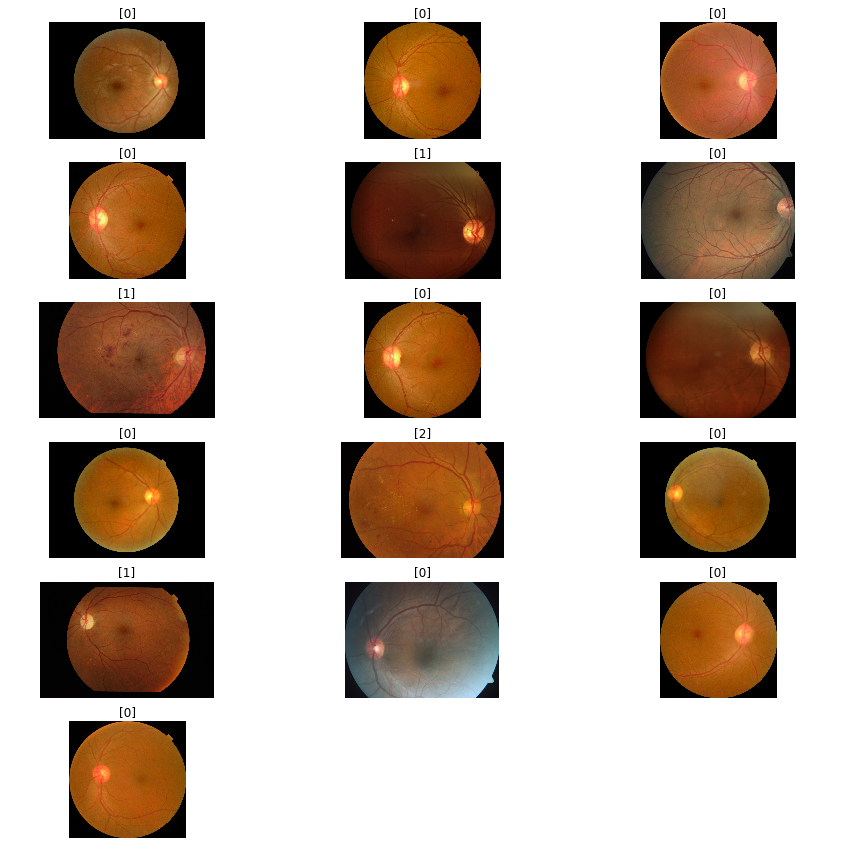

In [10]:
imgs = []
for p in train_df.id_code:
    imgs.append(p)
    if len(imgs) == 16: break
p_show(imgs)

In [11]:
#The Code from: https://www.kaggle.com/ratthachat/aptos-updated-albumentation-meets-grad-cam

def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [12]:
class MyDataset(Dataset):
    
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        label = self.df.diagnosis.values[idx]
        label = np.expand_dims(label, -1)
        
        p = self.df.id_code.values[idx]
        p_path = expand_path(p)
        image = cv2.imread(p_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = crop_image_from_gray(image)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , 30) ,-4 ,128)
        image = transforms.ToPILImage()(image)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [13]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation((-120, 120)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

trainset     = MyDataset(train_df, transform =train_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
valset       = MyDataset(val_df, transform   =train_transform)
val_loader   = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False, num_workers=4)

In [14]:
model = EfficientNet.from_name('efficientnet-b3')
model.load_state_dict(torch.load('../input/efficientnet-pytorch/efficientnet-b3-c8376fa2.pth'))
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, num_classes)
model.cuda()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_siz

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model, optimizer = amp.initialize(model, optimizer, opt_level="O1",verbosity=0)

In [16]:
def train_model(epoch):
    model.train() 
        
    avg_loss = 0.
    optimizer.zero_grad()
    for idx, (imgs, labels) in enumerate(train_loader):
        imgs_train, labels_train = imgs.cuda(), labels.float().cuda()
        output_train = model(imgs_train)
        loss = criterion(output_train,labels_train)
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        optimizer.step() 
        optimizer.zero_grad() 
        avg_loss += loss.item() / len(train_loader)
        
    return avg_loss

def test_model():
    
    avg_val_loss = 0.
    model.eval()
    with torch.no_grad():
        for idx, (imgs, labels) in enumerate(val_loader):
            imgs_vaild, labels_vaild = imgs.cuda(), labels.float().cuda()
            output_test = model(imgs_vaild)
            avg_val_loss += criterion(output_test, labels_vaild).item() / len(val_loader)
        
    return avg_val_loss

In [17]:
best_avg_loss = 100.0
n_epochs      = 10

for epoch in range(n_epochs):
    
    print('lr:', scheduler.get_lr()[0]) 
    start_time   = time.time()
    avg_loss     = train_model(epoch)
    avg_val_loss = test_model()
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t time={:.2f}s'.format(
        epoch + 1, n_epochs, avg_loss, avg_val_loss, elapsed_time))
    
    if avg_val_loss < best_avg_loss:
        best_avg_loss = avg_val_loss
        torch.save(model.state_dict(), 'weight_best.pt')
    
    scheduler.step()

lr: 0.001
Epoch 1/10 	 loss=0.6188 	 val_loss=0.8743 	 time=629.47s
lr: 0.001
Epoch 2/10 	 loss=0.3873 	 val_loss=0.4238 	 time=628.18s
lr: 0.001
Epoch 3/10 	 loss=0.3364 	 val_loss=0.3789 	 time=627.70s
lr: 0.001
Epoch 4/10 	 loss=0.3006 	 val_loss=0.3780 	 time=630.60s
lr: 0.001
Epoch 5/10 	 loss=0.2765 	 val_loss=0.4833 	 time=627.94s
lr: 1e-05
Epoch 6/10 	 loss=0.2209 	 val_loss=0.2503 	 time=629.56s
lr: 0.0001
Epoch 7/10 	 loss=0.1893 	 val_loss=0.2351 	 time=628.60s
lr: 0.0001
Epoch 8/10 	 loss=0.1764 	 val_loss=0.2436 	 time=629.98s
lr: 0.0001
Epoch 9/10 	 loss=0.1716 	 val_loss=0.2439 	 time=629.80s
lr: 0.0001
Epoch 10/10 	 loss=0.1594 	 val_loss=0.2443 	 time=628.61s
